# Regularization in Computer vision: synthetic image generation

## Image augmentation with Albumentations

In [ ]:
!kaggle datasets download -d karakaggle/kaggle-cat-vs-dog-dataset
!unzip kaggle-cat-vs-dog-dataset.zip

In [11]:
from glob import glob
import os

cats_folder = 'kagglecatsanddogs_3367a/PetImages/Cat/'
dogs_folder = 'kagglecatsanddogs_3367a/PetImages/Dog/'

cats_paths = sorted(glob(cats_folder + '*.jpg'))
dogs_paths = sorted(glob(dogs_folder + '*.jpg'))
train_ratio = 0.8

os.mkdir(cats_folder + 'train')
os.mkdir(cats_folder + 'test')
os.mkdir(dogs_folder + 'train')
os.mkdir(dogs_folder + 'test')

for i in range(len(cats_paths)):
    if i <= train_ratio * len(cats_paths):
        os.rename(cats_paths[i], cats_folder + 'train/' + cats_paths[i].split('/')[-1])
    else:
        os.rename(cats_paths[i], cats_folder + 'test/' + cats_paths[i].split('/')[-1])
        
for i in range(len(dogs_paths)):
    if i <= train_ratio * len(dogs_paths):
        os.rename(dogs_paths[i], dogs_folder + 'train/' + dogs_paths[i].split('/')[-1])
    else:
        os.rename(dogs_paths[i], dogs_folder + 'test/' + dogs_paths[i].split('/')[-1])


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v3_small
from glob import glob
from PIL import Image

In [2]:
class DogsAndCats(Dataset) :

    def __init__(self, cats_folder: str, dogs_folder: str, transform, augment = None):
        self.cats_path = sorted(glob(f'{cats_folder}/*.jpg'))
        self.dogs_path = sorted(glob(f'{dogs_folder}/*.jpg'))
        self.images_path = self.cats_path + self.dogs_path
        self.labels = [0.]*len(self.cats_path) + [1.]*len(self.dogs_path)
        self.transform = transform
        self.augment = augment
        
    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        image = Image.open(self.images_path[idx]).convert('RGB')
        if self.augment is not None:
            image = self.augment(image=np.array(image))["image"]
        return self.transform(image), torch.tensor(self.labels[idx], dtype=torch.float32)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize((224, 224), antialias=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 20

In [4]:
trainset = DogsAndCats(
    'kagglecatsanddogs_3367a/PetImages/Cat/train/', 
    'kagglecatsanddogs_3367a/PetImages/Dog/train/', 
    transform=transform
)
train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = DogsAndCats(
    'kagglecatsanddogs_3367a/PetImages/Cat/test/', 
    'kagglecatsanddogs_3367a/PetImages/Dog/test/', 
    transform=transform
)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [5]:
def display_images(dataloader, classes = ['cat', 'dog']):
    plt.figure(figsize=(14, 10))

    images, labels = next(iter(dataloader))

    for idx in range(8):
        plt.subplot(2, 4, idx+1)
        plt.imshow(images[idx].permute(1, 2, 0).numpy() * 0.5 + 0.5)
        plt.title(classes[int(labels[idx].item())])
        plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


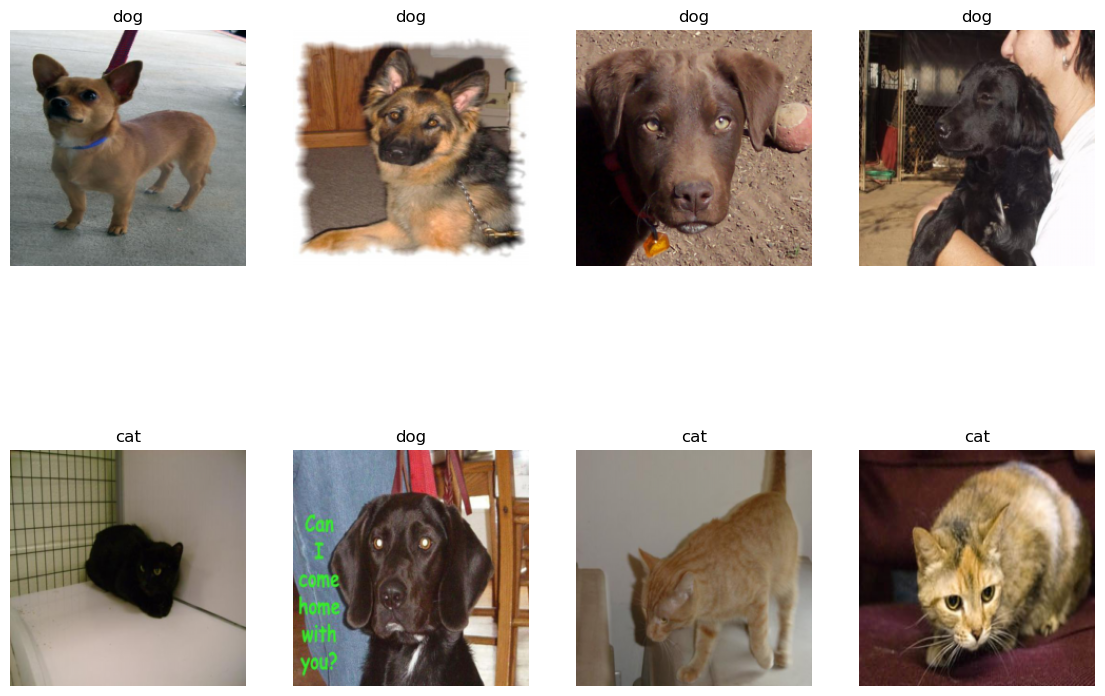

In [6]:
display_images(train_dataloader)

In [7]:
class Classifier(nn.Module):
    def __init__(self):
        super(classifier, self).__init__()
        self.mobilenet = mobilenet_v3_small()
        self.output_layer = nn.Linear(1000, 1)

    def forward(self, x):
        x = self.mobilenet(x)
        x = nn.Sigmoid()(self.output_layer(x))
        return x

In [ ]:
model = Classifier()
model = model.to(device)

In [9]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
def train_model(epochs, model, criterion, optimizer, device, train_dataloader, test_dataloader, trainset, testset):
    train_losses = []
    test_losses = []
    train_accuracy = []
    test_accuracy = []

    model = model.to(device)

    for epoch in range(epochs):
        ## Train the model on the training set
        running_train_loss = 0.
        correct = 0.
        # Switch to train mode
        model.train()
        # Loop over the batches in train set
        for i, data in enumerate(train_dataloader, 0):
            # Get the inputs: data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            # Add correct predictions for this batch
            correct += ((outputs > 0.5).squeeze(-1) == labels).float().sum()
            # Add current loss to running loss
            running_train_loss += loss.item()
        # Once epoch is over, compute and store the epoch loss
        train_epoch_loss = running_train_loss / len(train_dataloader)
        train_losses.append(train_epoch_loss)
        train_accuracy.append(correct.item() / len(trainset))

        ## Evaluate the model on the test set
        running_test_loss = 0.
        correct = 0.
        # Switch to eval model
        model.eval()
        with torch.no_grad():
            # Loop over the batches in test set
            for i, data in enumerate(test_dataloader, 0):
                # Get the inputs
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Compute forward propagation
                outputs = model(inputs)
                # Compute loss
                loss = criterion(outputs, labels.unsqueeze(1))
                # Add correct predictions for this batch
                correct += ((outputs > 0.5).squeeze(-1) == labels).float().sum()
                # Add to running loss
                running_test_loss += loss.item()
            # Compute and store the epoch loss
            test_epoch_loss = running_test_loss / len(test_dataloader)
            test_losses.append(test_epoch_loss)
            test_accuracy.append(correct.item() / len(testset))

        # Print stats
        print(f'[epoch {epoch + 1}] Training: loss={train_epoch_loss:.3f} accuracy={train_accuracy[-1]:.3f} |\
    \t Test: loss={test_epoch_loss:.3f} accuracy={test_accuracy[-1]:.3f}')
    
    return train_losses, test_losses, train_accuracy, test_accuracy

In [ ]:
train_losses, test_losses, train_accuracy, test_accuracy = train_model(
    epochs, model, criterion, optimizer, device, train_dataloader, test_dataloader, trainset, testset
)

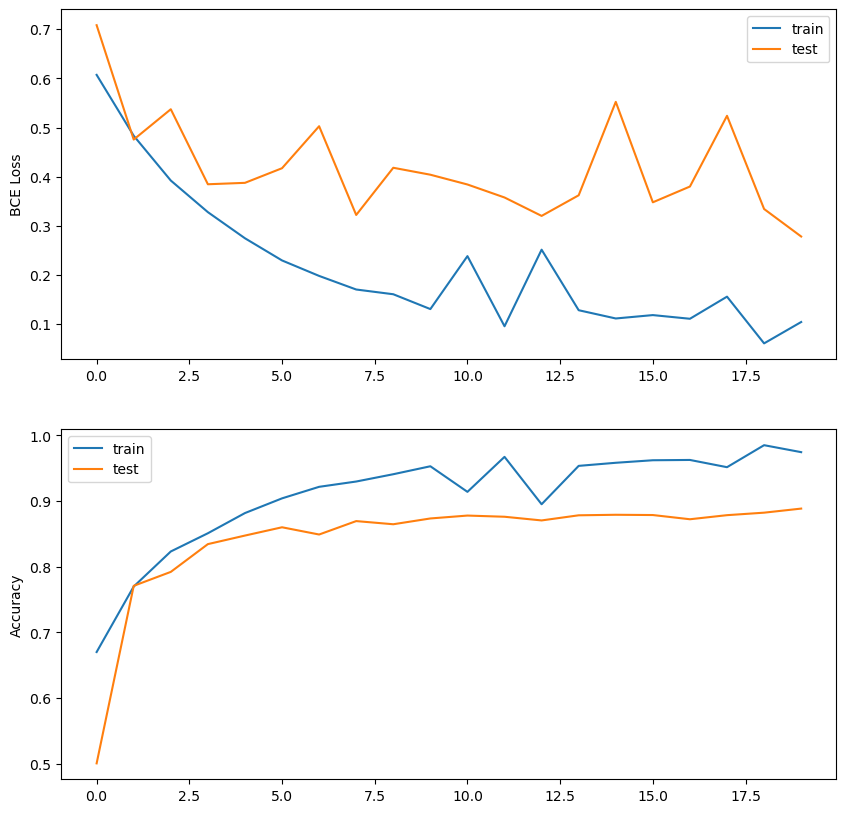

In [12]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.ylabel('BCE Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Training with image augmentation

In [13]:
import albumentations as A

augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

In [ ]:
augmented_trainset = DogsAndCats(
    'kagglecatsanddogs_3367a/PetImages/Cat/train/', 
    'kagglecatsanddogs_3367a/PetImages/Dog/train/', 
    transform=transform,
    augment=augment,
)
augmented_train_dataloader = DataLoader(augmented_trainset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


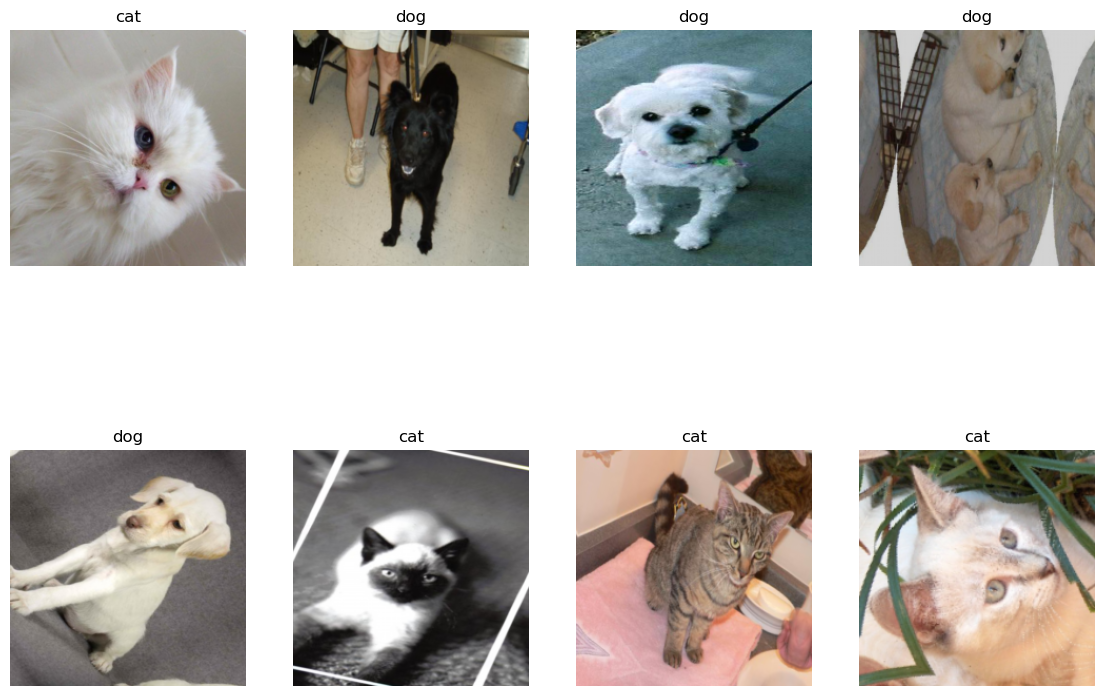

In [14]:
display_images(augmented_train_dataloader)

In [15]:
model = Classifier()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_losses, test_losses, train_accuracy, test_accuracy = train_model(
    epochs, model, criterion, optimizer, device, augmented_train_dataloader, test_dataloader, trainset, testset
)

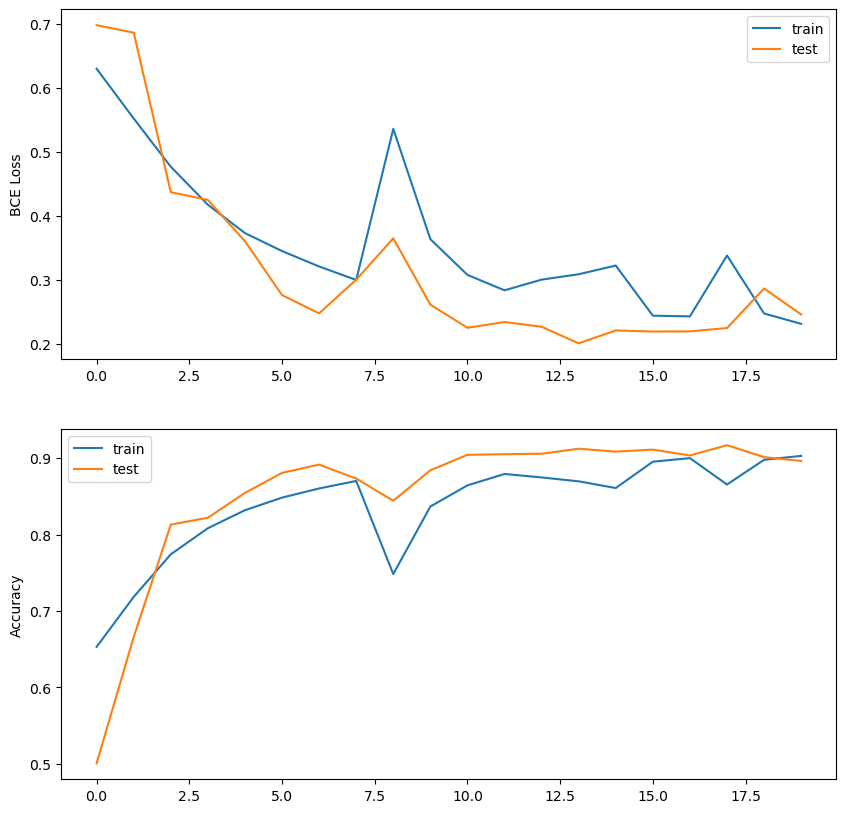

In [17]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.ylabel('BCE Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Creating synthetic images for object detection

In [4]:
from glob import glob
import os

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO

In [6]:
def read_labels(labels_path):
    res = []
    with open(labels_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            cls, xc, yc, w, h = line.strip().split(' ')
            res.append([int(float(cls)), float(xc), float(yc), float(w), float(h)])
        file.close()
    return res

In [6]:
def plot_labels(images_folder, labels_folder, classes):
    images_path = sorted(glob(images_folder + '/*.jpg'))
    labels_path = sorted(glob(labels_folder + '/*.txt'))
    
    plt.figure(figsize=(10, 6))

    for i in range(8):
        idx = np.random.randint(len(images_path))
        image = plt.imread(images_path[idx])
        labels = read_labels(labels_path[idx])
        
        for cls, xc, yc, w, h in labels:
            xc = int(xc*image.shape[1])
            yc = int(yc*image.shape[0])
            w = int(w*image.shape[1])
            h = int(h*image.shape[0])
            cv2.rectangle(image, (xc - w//2, yc - h//2), (xc + w//2 ,yc + h//2), (255,0,0), 2)
            cv2.putText(image, f'{classes[int(cls)]}', (xc-w//2, yc - h//2 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (1.,0.,0.), 1)
        plt.subplot(2, 4, i + 1)
        plt.imshow(image)
        plt.axis('off')

In [ ]:
!kaggle datasets download -d vincentv/qr-detection-yolo
!unzip qr-detection-yolo

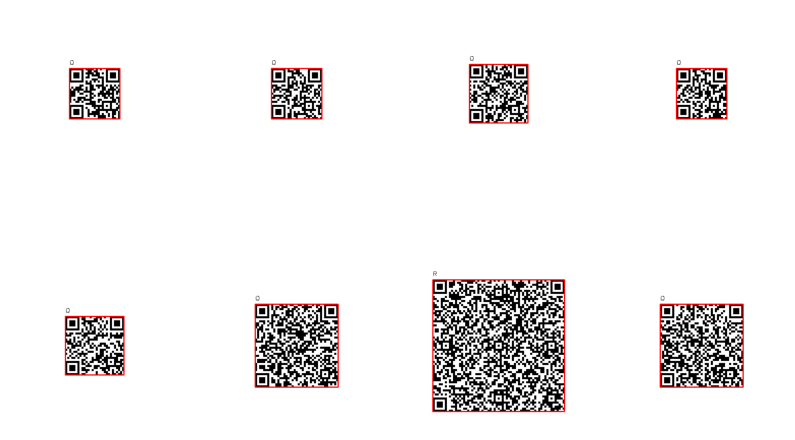

In [15]:
plot_labels('QR-detection-yolo/train/images/', 'QR-detection-yolo/train/labels/', 'QR Code')

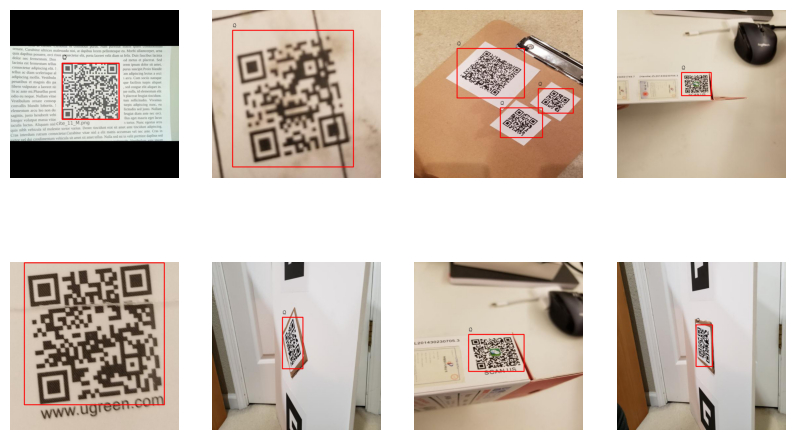

In [14]:
plot_labels('QR-detection-yolo/test/images/', 'QR-detection-yolo/test/labels/', 'QR Code')

In [7]:
def generate_synthetic_background_image_with_tag(
    n_images_to_generate: int,
    output_path: str,
    raw_tags_folder: str,
    background_images_path: str,
    labels_path: str,
    background_proba: float = 0.8,
  ):
    """Generate images with random tag and synthetic background.
    
    Parameters
    ----------
    n_images_to_generate : int
        The number of images to generate.

    output_path : str
        The output directory path where to store the generated images.
        If the path does not exist, the directory is created.

    raw_tags_folder : str
        Path to the folder containing the raw QR codes.

    background_images_path : str
        Path to the folder containing the background images.
        
    labels_path : str
        Path to the folder containing the labels. 
        Files must be in the same order as the ones in the raw_tags_folder.
        
    background_proba : float (optional, default=0.8)
        Probability to use a background image when generating a new sample.
    
    """
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    if not os.path.exists(output_path + '/images'):
        os.mkdir(output_path + '/images')
        os.mkdir(output_path + '/labels')

    # Instantiate the QR code augmentation
    composition = [
        A.ColorJitter(brightness=[.5, 1.], p=0.2),
        A.Perspective(fit_output=True, p=.9, pad_val=[250, 252, 254]),
        A.MotionBlur(p=0.5),
        A.Defocus(radius=(1, 5), p=0.5),
        A.RandomScale(p=0.5)
    ]
    transform = A.Compose(composition, bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

    # Load images paths
    tag_images = sorted(glob(raw_tags_folder + '/*.jpg'))
    tag_labels = sorted(glob(labels_path + '/*.txt'))
    if background_images_path is not None :
        bkg_images = glob(background_images_path + '/*.jpg')
    for idx in range(n_images_to_generate):
        i = np.random.randint(len(tag_images))
        # Convert tag format for albumentation
        tag_label = read_labels(tag_labels[i])
        tag_label = [tag[1:] + [0] for tag in tag_label]
        # Read and transform tag image
        tag_image = cv2.imread(tag_images[i])
        transformed = transform(image=tag_image, bboxes=tag_label, class_labels=['QR_code'])
        transformed_labels = np.array(transformed['bboxes'])
        transformed_image = transformed['image']

        if background_images_path is None or np.random.random() > background_proba:
            bkg_image = transformed_image
        else:
            h, w = transformed_image.shape[:2]
            # Get background image
            bkg_image = bkg_images[np.random.randint(len(bkg_images))]
            bkg_image = cv2.imread(bkg_image)
            bkg_image = cv2.resize(bkg_image, (0, 0), fx=0.5, fy=0.5)
            # Check background image is big enough
            if h >= bkg_image.shape[0] or w >= bkg_image.shape[1]:
                continue
            # Compute mask image
            i = np.random.randint(bkg_image.shape[0]-h)
            j = np.random.randint(bkg_image.shape[1]-w)
            # Compute tag with original image as background
            mask = (transformed_image[:, :, 0] == 250) & (transformed_image[:, :, 1] == 252) & (transformed_image[:, :, 2] == 254)
            mask = np.expand_dims(mask, -1).astype(int)
            tmp = transformed_image*(1 - mask) + bkg_image[i:i+h, j:j+w]*mask
            # Compute output image
            bkg_image[i:i+h, j:j+w] = tmp
            # Compute bounding boxes new coordinates
            transformed_labels[:,0] = (transformed_labels[:,0] * tag_image.shape[1] + j) / bkg_image.shape[1]
            transformed_labels[:,1] = (transformed_labels[:,1] * tag_image.shape[0] + i) / bkg_image.shape[0]
            transformed_labels[:,2] = transformed_labels[:,2] * tag_image.shape[1] / bkg_image.shape[1]
            transformed_labels[:,3] = transformed_labels[:,3] * tag_image.shape[0] / bkg_image.shape[0]

        # Apply one more transformation globally
        global_transform = A.Compose([
            A.ColorJitter(p=.5),
            A.BBoxSafeRandomCrop(p=0.5),
            A.MotionBlur(p=0.5),
            A.Defocus(radius=(1, 5), p=0.5),
        ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
        output = global_transform(image=bkg_image, bboxes=transformed_labels, class_labels=['tag'])
        transformed_labels = np.array(output['bboxes'])
        bkg_image = output['image']

        # Save image and labels
        output_img = output_path + f'/images/synthetic_image_{idx}.jpg'
        cv2.imwrite(output_img, bkg_image)
        output_label = output_path + f'/labels/synthetic_image_{idx}.txt'
        transformed_labels = [[int(x[-1])] + x[:-1] for x in transformed_labels.tolist()]
        np.savetxt(output_label, transformed_labels)


In [8]:
generate_synthetic_background_image_with_tag(
    n_images_to_generate=3000, 
    output_path='QR-detection-yolo/generated_qr_code_images/', 
    raw_tags_folder='QR-detection-yolo/train/images/', 
    background_images_path='QR-detection-yolo/background_images/', 
    labels_path='QR-detection-yolo/train/labels/'
)

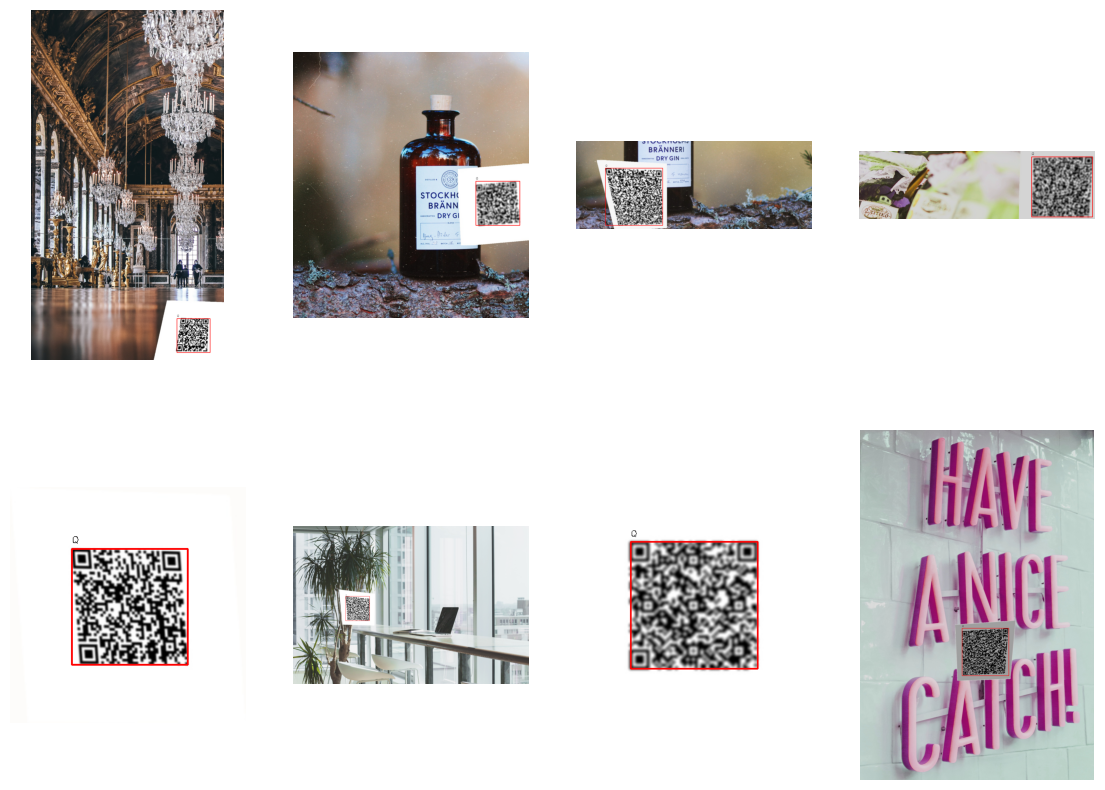

In [7]:
plot_labels(
    'QR-detection-yolo/generated_qr_code_images/images/', 
    'QR-detection-yolo/generated_qr_code_images/labels/', 
    'QR Code'
)

#### Model training

In [ ]:
!printf "train: ../../QR-detection-yolo/generated_qr_code_images/images \nval: ../../QR-detection-yolo/test/images \nnc: 1\nnames: ['QR_CODE']" > data_qr_generated.yaml
!rm ~/.config/Ultralytics/settings.yaml

In [ ]:
# Create a new YOLO model with pretrained weights
model = YOLO('yolov8n.pt')

In [ ]:
# Train the model for 50 epochs
model.train(data='data_qr_generated.yaml', epochs=50, lr0=0.001, name='generated_qrcode')

In [10]:
def plot_results_random_images(test_images, model, classes=['QR_code']):
    images = glob(test_images + '/*.jpg')
    plt.figure(figsize=(14, 10))
    for i in range(8):
        idx = np.random.randint(len(images))
        result = model.predict(images[idx])
        image = result[0].orig_img.copy()
        raw_res = result[0].boxes.data
        for detection in raw_res:
            x1, y1, x2, y2, p, cls = detection.cpu().tolist()
            cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0), 2)
            cv2.putText(image, f'{classes[int(cls)]}', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)

        plt.subplot(2, 4, i + 1)
        plt.axis('off')
        plt.imshow(image)


image 1/1 /home/vince/Documents/Freelance/packt/regularization-cookbook/11_synthetic_image_generation/QR-detection-yolo/test/images/glareimage006_jpg.rf.896b8eb1939602909e7be3567deddc46.jpg: 640x640 1 QR_CODE, 2.0ms
Speed: 0.1ms preprocess, 2.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vince/Documents/Freelance/packt/regularization-cookbook/11_synthetic_image_generation/QR-detection-yolo/test/images/709.jpg: 640x640 1 QR_CODE, 2.0ms
Speed: 0.2ms preprocess, 2.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vince/Documents/Freelance/packt/regularization-cookbook/11_synthetic_image_generation/QR-detection-yolo/test/images/rotationsimage029_jpg.rf.d0f5054e9a2c25c27151828a3e6f8f6e.jpg: 640x640 3 QR_CODEs, 2.0ms
Speed: 0.2ms preprocess, 2.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vince/Documents/Freelance/packt/regularization-cookbook/11_synthetic_image_generation/QR-

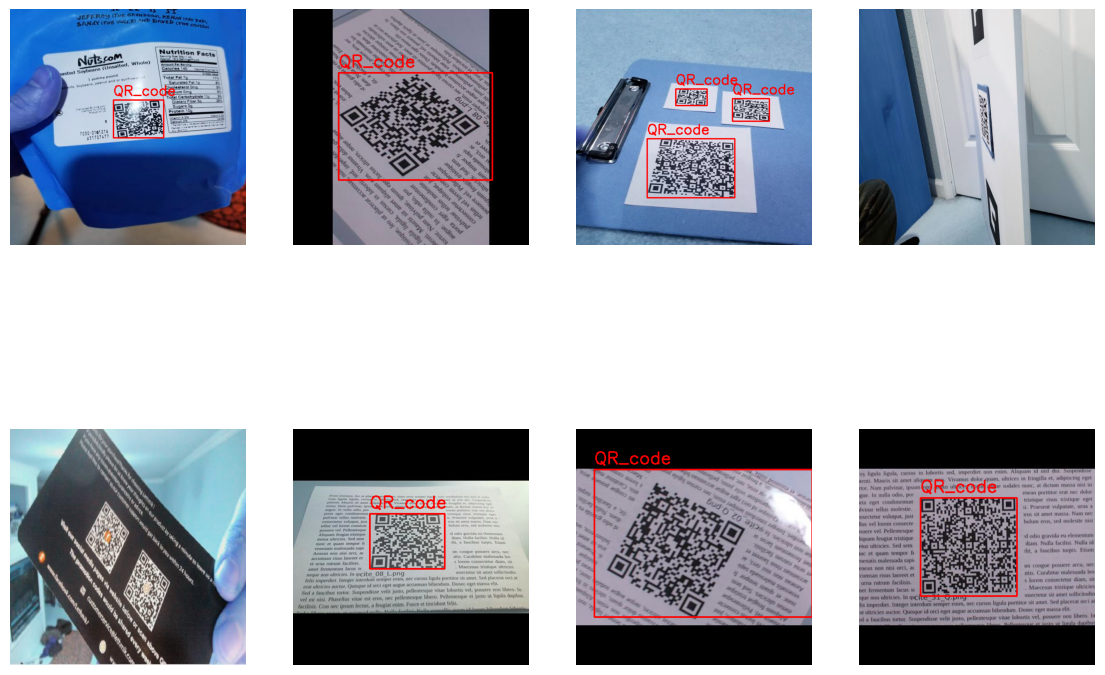

In [14]:
# Load the best weights
model = YOLO('runs/detect/generated_qrcode/weights/best.pt')
# Plot the results
plot_results_random_images('QR-detection-yolo/test/images/', model)

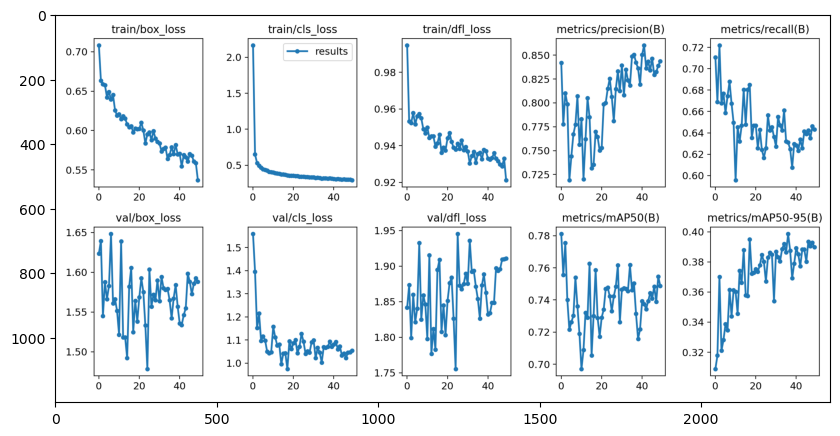

In [15]:
plt.figure(figsize=(10, 8))
plt.imshow(plt.imread('runs/detect/generated_qrcode/results.png'))

### There's more

In [2]:
import openai
import urllib
from PIL import Image
import matplotlib.pyplot as plt

openai.api_key = 'xx-xxx'

In [3]:
def get_mask_to_complete(image_path, label_path, output_filename, margin: int = 100):
    image = plt.imread(image_path)
    labels = read_labels(label_path)
    output_mask = np.zeros(image.shape[:2])
    for cls, xc, yc, w, h in labels:
        xc = int(xc*image.shape[1])
        yc = int(yc*image.shape[0])
        w = int(w*image.shape[1])
        h = int(h*image.shape[0])
        output_mask[yc-h//2-margin:yc+h//2+margin, xc-w//2-margin:xc+w//2+margin] = 255
    output_mask = np.concatenate([image, np.expand_dims(output_mask, -1)], axis=-1).astype(np.uint8)
    # Save the images
    output_mask_filename = output_filename.split('.')[0] + '_mask.png'
    plt.imsave(output_filename, image)
    plt.imsave(output_mask_filename, output_mask)
    return output_mask_filename

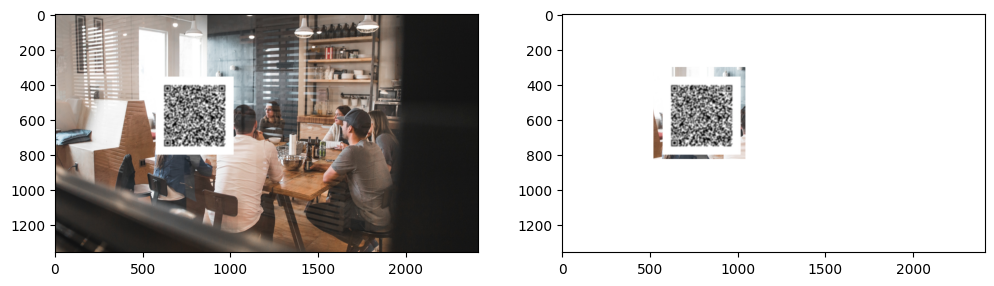

In [7]:
output_image_filename = 'image_edit.png'

mask_filename = get_mask_to_complete(
    'QR-detection-yolo/generated_qr_code_images/images/synthetic_image_0.jpg', 
    'QR-detection-yolo/generated_qr_code_images/labels/synthetic_image_0.txt',
    output_image_filename
)
# Display the masked image and the original image side by side
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.imshow(plt.imread(output_image_filename))
plt.subplot(1, 2, 2)
plt.imshow(plt.imread(mask_filename))

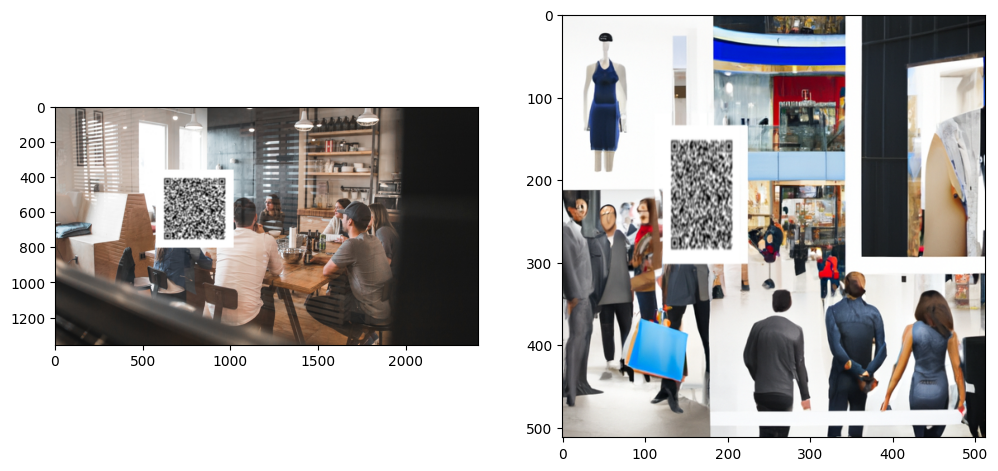

In [10]:
# Query openAI API to generate image
response = openai.Image.create_edit(
  image=open(output_image_filename, 'rb'),
  mask=open(mask_filename, 'rb'),
  prompt="A store in background",
  n=1,
  size="512x512"
)

# Download and display the generated image
plt.figure(figsize=(12, 10))
image_url = response['data'][0]['url']
plt.subplot(1, 2, 1)
plt.imshow(plt.imread(output_image_filename))
plt.subplot(1, 2, 2)
plt.imshow(np.array(Image.open(urllib.request.urlopen(image_url))))

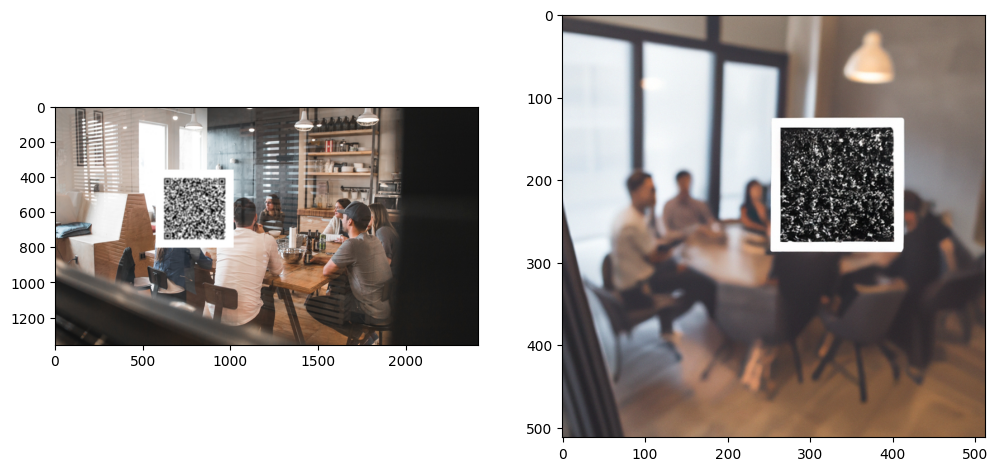

In [13]:
# Query to create variation of a given image
response = openai.Image.create_variation(
  image=open(output_image_filename, "rb"),
  n=1,
  size="512x512"
)
# Download and display the generated image
plt.figure(figsize=(12, 10))
image_url = response['data'][0]['url']
plt.subplot(1, 2, 1)
plt.imshow(plt.imread(output_image_filename))
plt.subplot(1, 2, 2)
plt.imshow(np.array(Image.open(urllib.request.urlopen(image_url))))

## Real-time style transfer

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.models import vgg16, VGG16_Weights
from glob import glob
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import ExponentialLR
import albumentations as A
import tqdm

In [2]:
class AnimeStyleDataset(Dataset):
    def __init__(self, input_path: str, output_path: str, transform, augment = None):
        self.input_paths = sorted(glob(f'{input_path}/*.png'))
        self.output_paths = sorted(glob(f'{output_path}/*.png'))
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.input_paths)
    
    def __getitem__(self, idx):
        input_img = plt.imread(self.input_paths[idx])
        output_img = plt.imread(self.output_paths[idx])  
        
        if self.augment:
            augmented = self.augment(image=input_img)
            input_img = augmented['image']
            output_img = A.ReplayCompose.replay(augmented['replay'], image=output_img)['image']       

        return self.transform(input_img), self.transform(output_img)

In [3]:
augment = A.ReplayCompose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomCropFromBorders(0.2, 0.2, 0.2, 0.2, p=0.5)
])

In [4]:
batch_size = 12
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize((512, 512), antialias=True),
    transforms.Normalize(mean, std),
])

In [ ]:
!kaggle datasets download -d vincentv/anime-style-transfer
!unzip anime-style-transfer.zip

In [6]:
trainset = AnimeStyleDataset(
    'anime-style-transfer/train/images/', 
    'anime-style-transfer/train/labels/', 
    transform=transform,
    augment=augment,
)
train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = AnimeStyleDataset(
    'anime-style-transfer/test/images/', 
    'anime-style-transfer/test/labels/', 
    transform=transform,
)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [7]:
def unnormalize(x, mean, std):
    x = np.asarray(x, dtype=np.float32)
    for dim in range(3):
        x[:, :, dim] = (x[:, :, dim] * std[dim]) + mean[dim]

    return x 

/home/vince/anaconda3/lib/python3.10/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: RandomCropFromBorders could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(


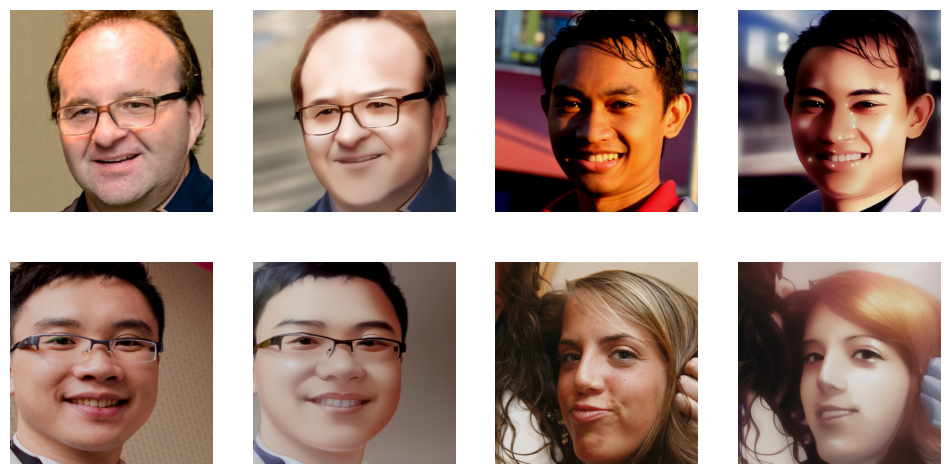

In [8]:
plt.figure(figsize=(12, 6))

images, labels = next(iter(train_dataloader))

for idx in range(4):
    plt.subplot(2, 4, idx*2+1)
    plt.imshow(unnormalize(images[idx].permute(1, 2, 0).numpy(), mean, std))
    plt.axis('off')
    plt.subplot(2, 4, idx*2+2)
    plt.imshow(unnormalize(labels[idx].permute(1, 2, 0).numpy(), mean, std))
    plt.axis('off')


In [8]:
model = smp.UnetPlusPlus(
                encoder_name='timm-mobilenetv3_large_100',
                encoder_weights='imagenet',
                in_channels=3,
                classes=3,
            )
model = model.to(device)

In [9]:
class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(vgg16(weights=VGG16_Weights.DEFAULT).features[:4].eval())
        blocks.append(vgg16(weights=VGG16_Weights.DEFAULT).features[4:9].eval())
        blocks.append(vgg16(weights=VGG16_Weights.DEFAULT).features[9:16].eval())
        blocks.append(vgg16(weights=VGG16_Weights.DEFAULT).features[16:23].eval())
        for block in blocks:
            block = block.to(device)
            for param in block.parameters():
                param.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate

    def forward(self, input, target):
        input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
        target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for i, block in enumerate(self.blocks):
            x = block(x)
            y = block(y)
            loss += torch.nn.functional.l1_loss(x, y)
            act_x = x.reshape(x.shape[0], x.shape[1], -1)
            act_y = y.reshape(y.shape[0], y.shape[1], -1)
            gram_x = act_x @ act_x.permute(0, 2, 1)
            gram_y = act_y @ act_y.permute(0, 2, 1)
            loss += torch.nn.functional.l1_loss(gram_x, gram_y)
        return loss


In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.995)
vgg_loss = VGGPerceptualLoss()

content_loss_weight=1.
style_loss_weight=5e-4

In [11]:
def train_style_transfer(
    model,
    train_dataloader,
    test_dataloader,
    vgg_loss,
    content_loss_weight,
    style_loss_weight,
    device,
    epochs,
):
    train_losses = []
    test_losses = []

    model = model.to(device)

    for epoch in range(epochs):
        ## Train the model on the training set
        running_train_loss = 0.
        running_test_loss = 0.
        correct = 0.
        # Switch to train mode
        model.train()
        # Loop over the batches in train set
        for i, data in tqdm.tqdm(enumerate(train_dataloader, 0)):
            # Get the inputs: data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward + backward + optimize
            outputs = model(inputs)
            style_loss = vgg_loss(outputs, labels)
            content_loss = torch.nn.functional.l1_loss(outputs, labels)
            loss = style_loss_weight*style_loss + content_loss_weight*content_loss

            loss.backward()
            optimizer.step()
            # Add correct predictions for this batch
            # Add current loss to running loss
            running_train_loss += loss.item()

        # Switch to eval model
        model.eval()
        with torch.no_grad():
            # Loop over the batches in test set
            for i, data in enumerate(test_dataloader, 0):
                # Get the inputs
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Compute forward propagation
                outputs = model(inputs)
                # Compute loss
                style_loss = vgg_loss(outputs, labels)
                content_loss = torch.nn.functional.l1_loss(outputs, labels)
                loss = style_loss_weight*style_loss + content_loss_weight*content_loss
                # Add to running loss
                running_test_loss += loss.item()

        scheduler.step()
        # Once epoch is over, compute and store the epoch loss
        train_epoch_loss = running_train_loss / len(train_dataloader)
        train_losses.append(train_epoch_loss)
        test_epoch_loss = running_test_loss / len(test_dataloader)
        test_losses.append(test_epoch_loss)
        # Print stats
        print(f'[epoch {epoch + 1}] Training loss={train_epoch_loss:.3f} | Test loss={test_epoch_loss:.3f}')

    return train_losses, test_losses

In [ ]:
train_losses, test_losses = train_style_transfer(
    model,
    train_dataloader, 
    test_dataloader, 
    vgg_loss, 
    content_loss_weight,
    style_loss_weight,
    device,
    epochs=50,
)

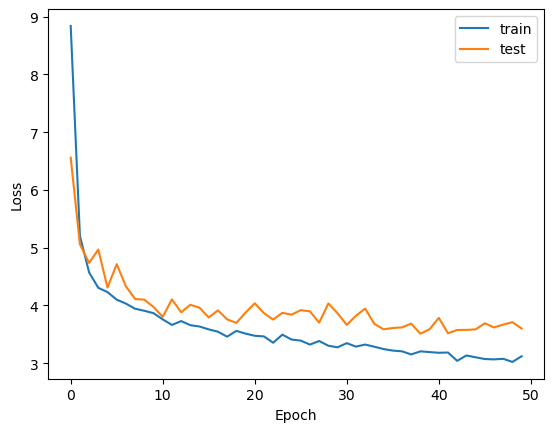

In [15]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

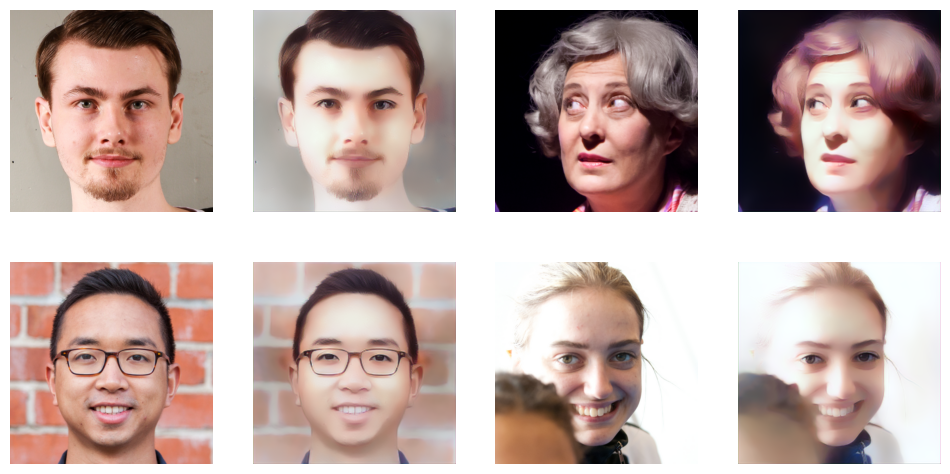

In [17]:
images, labels = next(iter(test_dataloader))

with torch.no_grad():
    outputs = model(images.to(device)).cpu()
    
plt.figure(figsize=(12, 6))
for idx in range(4):
    plt.subplot(2, 4, idx*2+1)
    plt.imshow(unnormalize(images[idx].permute(1, 2, 0).numpy(), mean, std))
    plt.axis('off')
    plt.subplot(2, 4, idx*2+2)
    plt.imshow(unnormalize(outputs[idx].permute(1, 2, 0).numpy(), mean, std).clip(0, 1))
    plt.axis('off')